In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None) 

%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

# EDA

1. Check for dtypes
2. Check for duplicates in data --> be sure they are real duplicates
3. Check for missing values --> which strategy for imputation will work?
4. Check distribution of target with skewness and kurtosis / Imbalance
5. Check for outliers --> remove or transform data with log-transformation or Box-Cox transformation or impute
6. Correlation among variables: check for multi-collinearity
7. Correlation between variables and target

In Transformers:

7. Imputing missing values
8. Scaling
9. Encoding caterogiral features --> high cardinality use hashing 


### Goal
predict whether a reservation has a no-show --> no-show is a form of anomaly, so in stead of using classification, we use anomaly (outlier) detection in this case.

Features that form data leakage:
- is_cancelled
- reservation_status_date 
- assigned_room_type

In [13]:
df = pd.read_csv('../data/hotel_bookings.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.shape

(119390, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

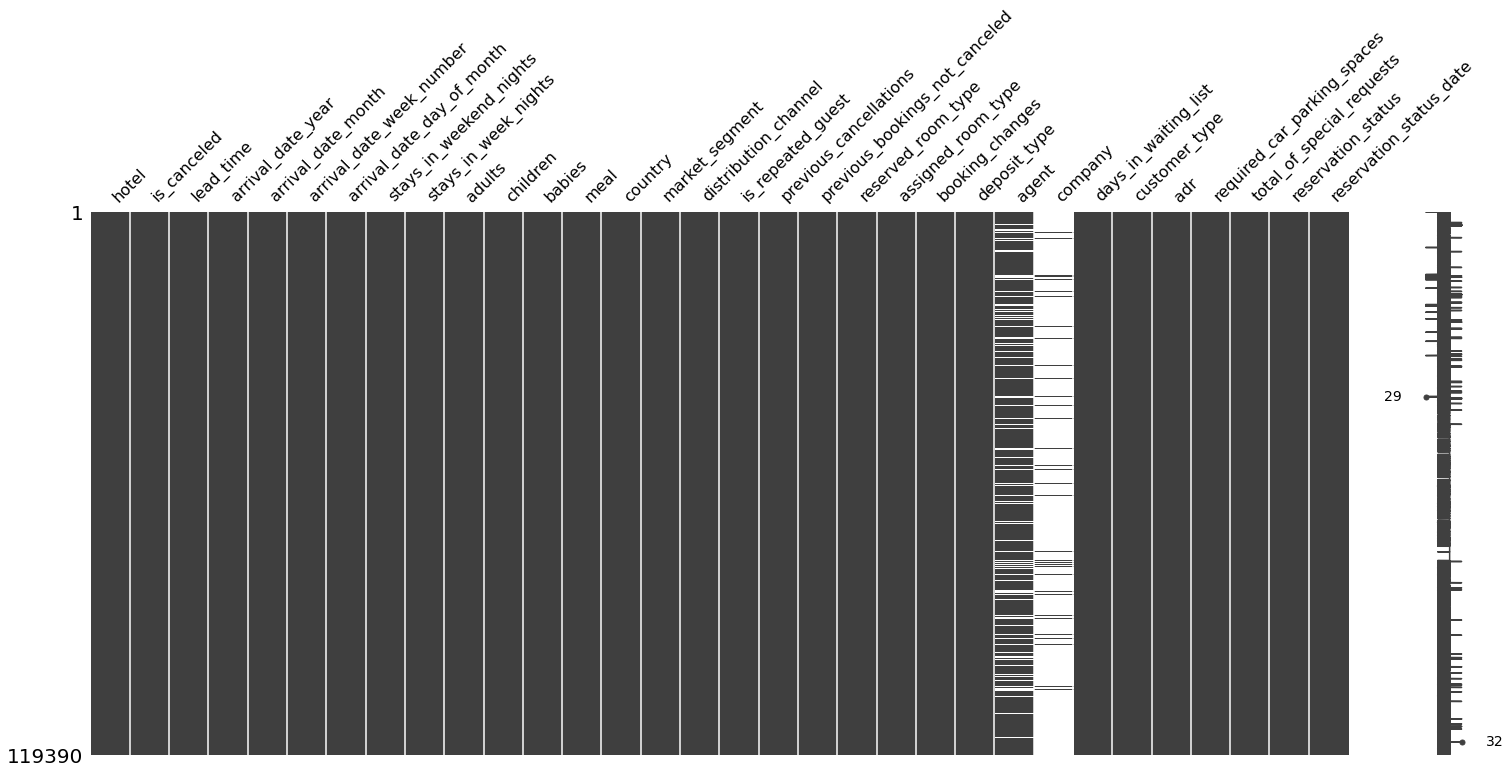

In [6]:
import missingno as msno
msno.matrix(df)

In [7]:
def get_missing_values(df):
    return {col: round((df[col].isna().sum())/len(df)*100, 1) for col in df.columns}

In [8]:
get_missing_values(df)

{'hotel': 0.0,
 'is_canceled': 0.0,
 'lead_time': 0.0,
 'arrival_date_year': 0.0,
 'arrival_date_month': 0.0,
 'arrival_date_week_number': 0.0,
 'arrival_date_day_of_month': 0.0,
 'stays_in_weekend_nights': 0.0,
 'stays_in_week_nights': 0.0,
 'adults': 0.0,
 'children': 0.0,
 'babies': 0.0,
 'meal': 0.0,
 'country': 0.4,
 'market_segment': 0.0,
 'distribution_channel': 0.0,
 'is_repeated_guest': 0.0,
 'previous_cancellations': 0.0,
 'previous_bookings_not_canceled': 0.0,
 'reserved_room_type': 0.0,
 'assigned_room_type': 0.0,
 'booking_changes': 0.0,
 'deposit_type': 0.0,
 'agent': 13.7,
 'company': 94.3,
 'days_in_waiting_list': 0.0,
 'customer_type': 0.0,
 'adr': 0.0,
 'required_car_parking_spaces': 0.0,
 'total_of_special_requests': 0.0,
 'reservation_status': 0.0,
 'reservation_status_date': 0.0}

The amount of missing values for the feature company is 94%. Therefore we drop this feature.
The missing values of 'agent' will be imputed later on in the pipeline.

Check for duplicated records in the dataset by checking without subset.

In [9]:
df.duplicated(subset=None).sum()

31994

It seems 31.994 records are duplicated. Therefore we will only keep the first ones.

# Distributions and frequencies

In [10]:
from hotelbooking.plots.plots import create_countplots, create_distplots

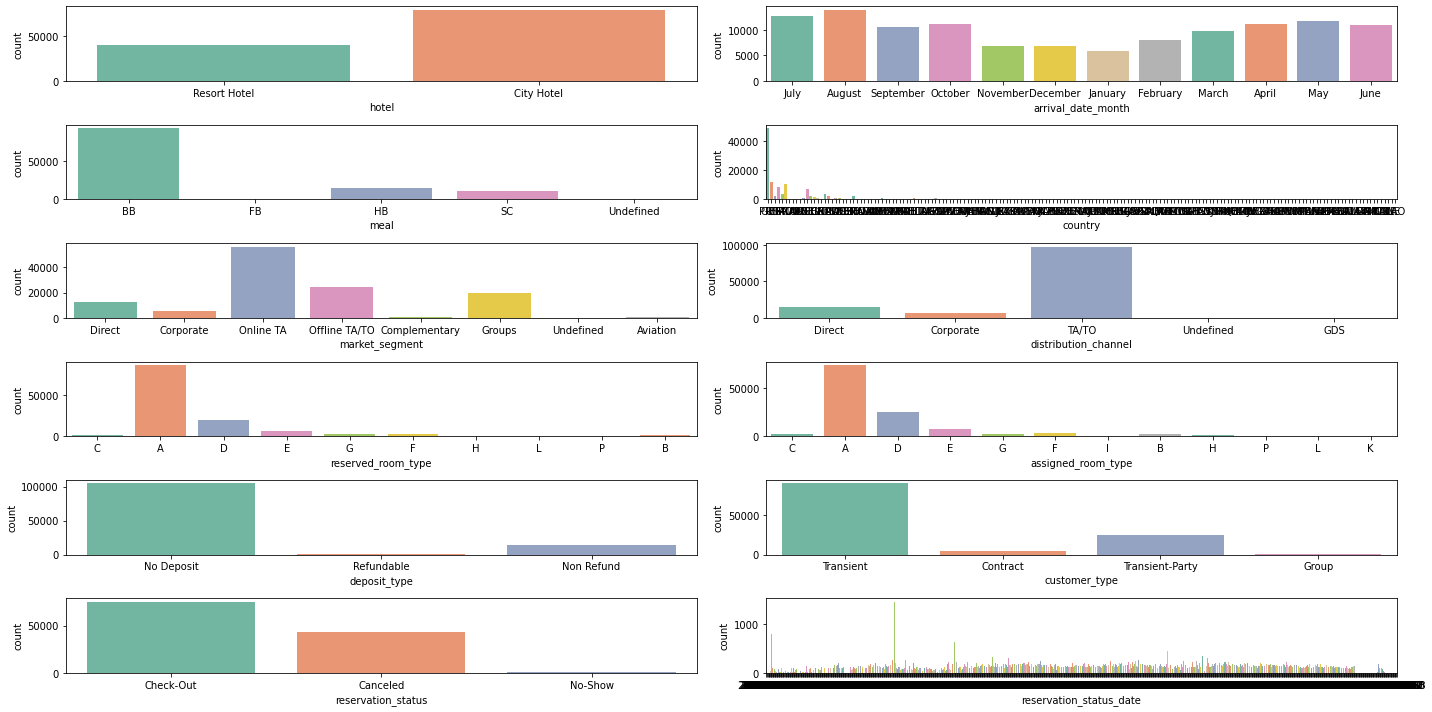

In [11]:
create_countplots(df)

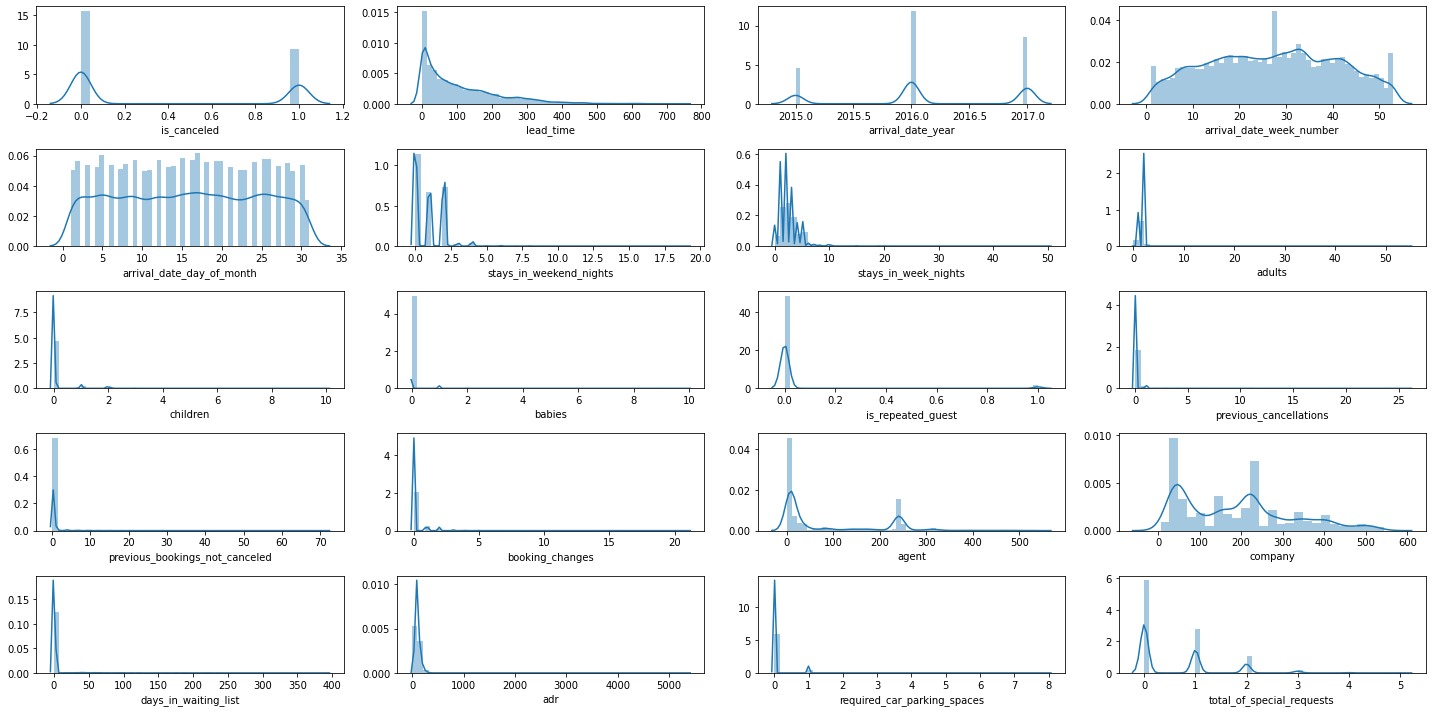

In [12]:
create_distplots(df, cols=4)

As we can see, non of the numerical features have a normal distribution and almost all of them are heavily skewed. However, since we are going to use an isolation forest, we don't need to transform or scale the data.

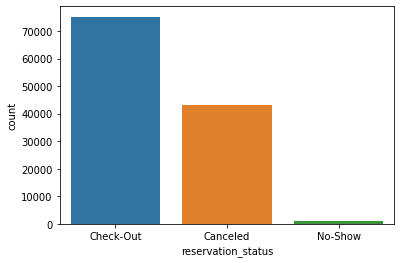

In [14]:
sns.countplot(df['reservation_status'])

The target is in this case is reservation status. As you can see in the count plot, the amount of no-show is extremely small compared to check-out and cancelation.

We could approach this problem as a standard imbalanced classification problem. However, since we are particularly interested in no-show, we could approach this problem as an anomaly detection problem. 

# Check for multi-collinearity 

In [17]:
from hotelbooking.plots.plots import plot_correlation_heatmap

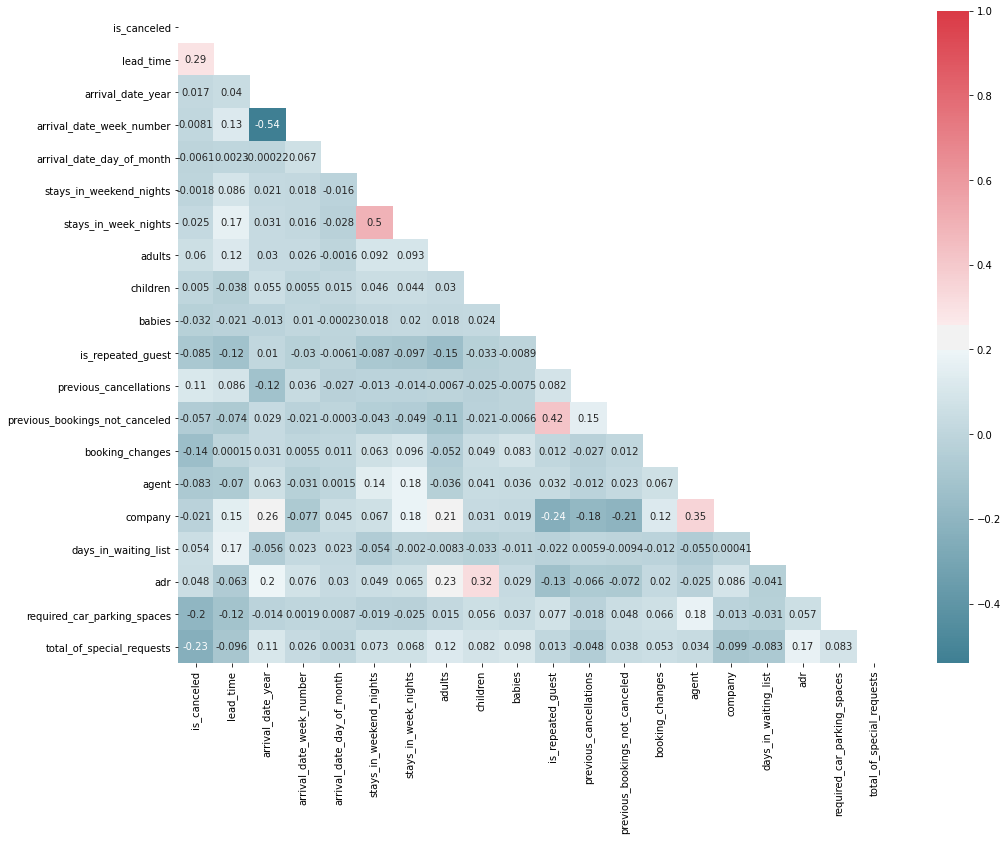

In [19]:
plot_correlation_heatmap(df, 16, 12)

None of the numerical features are highly correlated among each other.

In [20]:
from hotelbooking.plots.plots import plot_kde_categorical_target

/Users/nhoogeveenxccelerated.com/Desktop/Projects/HotelBooking/venv/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/nhoogeveenxccelerated.com/Desktop/Projects/HotelBooking/venv/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/nhoogeveenxccelerated.com/Desktop/Projects/HotelBooking/venv/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/nhoogeveenxccelerated.com/Desktop/Projects/HotelBooking/venv/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/nhoogeveenxccelerated.com/Desktop/Projects/HotelBooki

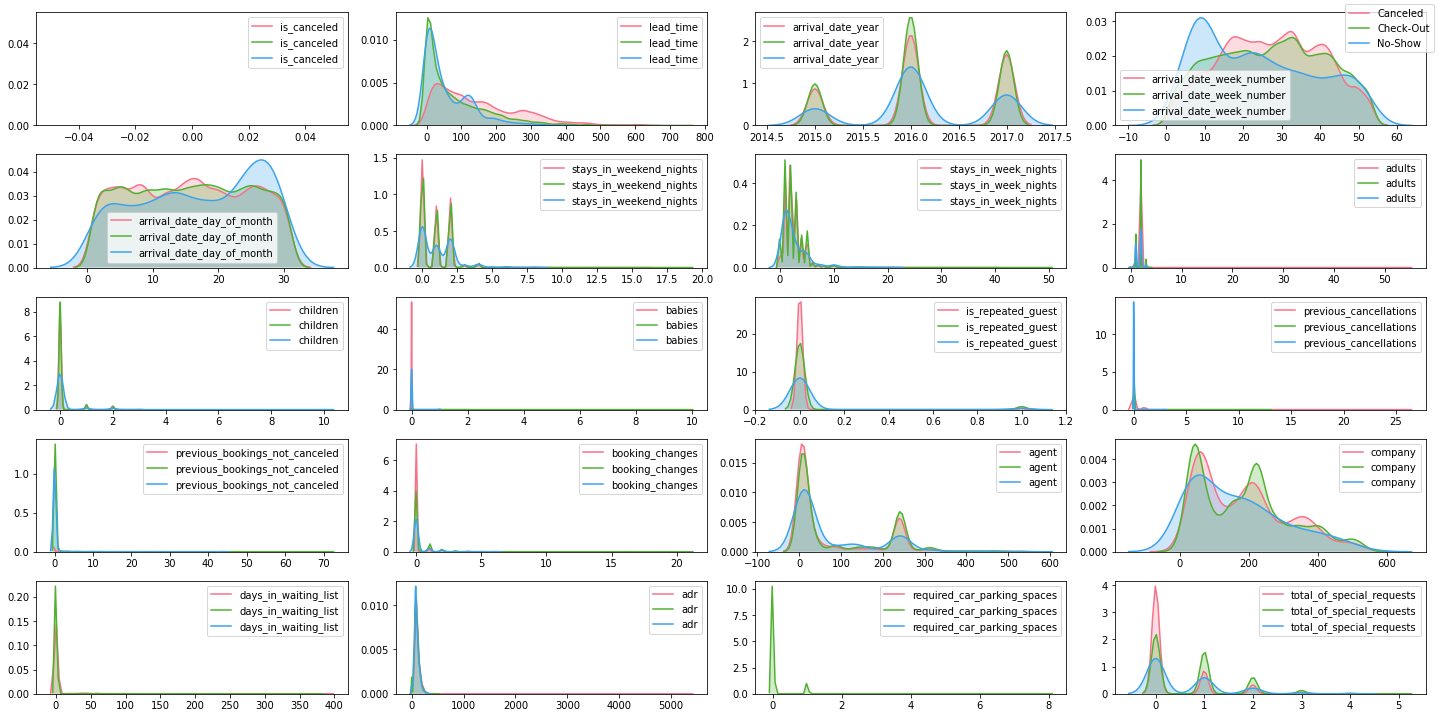

In [21]:
plot_kde_categorical_target(df, 'reservation_status')

It seems like the required car parking spaces is always 0, except for some cases where a customer did check-out. Therefore it seems like the parking spaces data is only recorded after showing up at the hotel. Therefore, this feature is also considered as data leakage and will therefore be removed.

In [35]:
print(df.loc[lambda d: d['reservation_status'] == 'No-Show']['required_car_parking_spaces'].max())
print(df.loc[lambda d: d['reservation_status'] == 'Canceled']['required_car_parking_spaces'].max())
print(df.loc[lambda d: d['reservation_status'] == 'Check-Out']['required_car_parking_spaces'].max())

0
0
8


# Encoding Cyclical Features

We will need to encode features like date week number, day of the month, since these are cyclical features. Therefore we cannot simple encode them with one-hot-encoding for example.

In [65]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Leadtime_Log,lead_time_log
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,5.837730,5.837730
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,6.603944,6.603944
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2.079442,2.079442
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2.639057,2.639057
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2.708050,2.708050


In order to encode cyclical features, we first need to transform them to numerical data. 

In [83]:
def replace_months(df):
    import calendar
    months = dict((v,k) for k,v in enumerate(calendar.month_name))
    
    return df.assign(
        arrival_date_month = lambda d: df['arrival_date_month'].map(months)
    )

In [84]:
replace_months(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Leadtime_Log,lead_time_log
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,5.837730,5.837730
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,6.603944,6.603944
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2.079442,2.079442
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2.639057,2.639057
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03,2.708050,2.708050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,8,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06,3.178054,3.178054
119386,City Hotel,0,102,2017,8,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07,4.634729,4.634729
119387,City Hotel,0,34,2017,8,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07,3.555348,3.555348
119388,City Hotel,0,109,2017,8,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07,4.700480,4.700480


In [64]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [90]:
def encode_cyclical_features(df):
    return df.assign(
        arrival_date_month_sin = lambda d: np.sin(2 * np.pi * d['arrival_date_month']/12),
        arrival_date_month_cos = lambda d: np.cos(2 * np.pi * d['arrival_date_month']/12),
        arrival_date_week_number_sin = lambda d: np.sin(2 * np.pi * d['arrival_date_week_number']/52),
        arrival_date_week_number_cos = lambda d: np.cos(2 * np.pi * d['arrival_date_week_number']/52),
        arrival_date_day_of_month_sin = lambda d: np.sin(2 * np.pi * d['arrival_date_day_of_month']/31),
        arrival_date_day_of_month_cos = lambda d: np.cos(2 * np.pi * d['arrival_date_day_of_month']/31)
    )

In [134]:
def change_labels(df):
    conditions = [
        (df['reservation_status'] == 'Check-Out') | (df['reservation_status'] == 'Canceled'),
        df['reservation_status'] == 'No-Show'
    ]
    
    choices = [1,-1]
    
    df['show_up'] = np.select(conditions, choices, 99)
    
    return df
        

# Amount of outliers

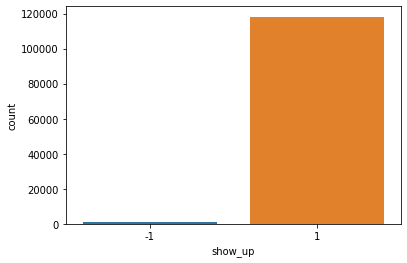

In [148]:
sns.countplot(df['show_up'])

In [153]:
df['show_up'].value_counts()

 1    118183
-1      1207
Name: show_up, dtype: int64

In [154]:
1207 / (118183 + 1207)

0.010109724432532038